## Lecture 22: Principal Components Analysis – Data 100, Fall 2020

Notebook originally by Josh Hug (Fall 2019)

Edits by Anthony D. Joseph and Suraj Rampure (Fall 2020)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

We often create visualizations in order to facilitate exploratory data analysis. For example, we might create scatterplots to explore the relationship between pairs of variables in a dataset.

The dataset below gives the "percentage body fat, age, weight, height, and ten body circumference measurements" for 252 men.

http://jse.amstat.org/v4n1/datasets.johnson.html

For simplicity, we read in only 8 of the provided attributes, yielding the given dataframe.

In [2]:
#http://jse.amstat.org/datasets/fat.txt
df3 = pd.read_fwf("data/fat.dat.txt", colspecs = [(17, 21), (23, 29), (35, 37),
                                             (39, 45), (48, 53), (73, 77),
                                            (80, 85), (88, 93)], header=None, names = ["% fat", "density", "age", "weight", "height", "neck", "chest", "abdomen"])
df3.head()

,% fat,density,age,weight,height,neck,chest,abdomen
0,12.3,1.0708,23,154.25,67.75,36.2,93.1,85.2
1,6.1,1.0853,22,173.25,72.25,38.5,93.6,83.0
2,25.3,1.0414,22,154.00,66.25,34.0,95.8,87.9
3,10.4,1.0751,26,184.75,72.25,37.4,101.8,86.4
4,28.7,1.0340,24,184.25,71.25,34.4,97.3,100.0


We see that percentage fat and density in g/cm^3 are almost completely redundant.

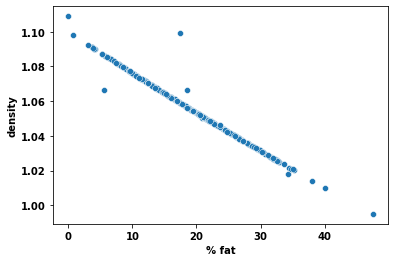

In [3]:
sns.scatterplot(data = df3, x = "% fat", y = "density");

By contrast, while there is a strong correlation between neck and chest measurements, the resulting data is very 2 dimensional.

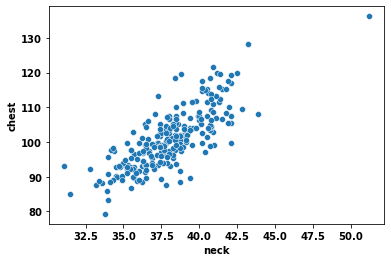

In [4]:
sns.scatterplot(data = df3, x = "neck", y = "chest");

Age and height show a small correlation as peolpe seem to get slightly smaller with greater age in this dataset.

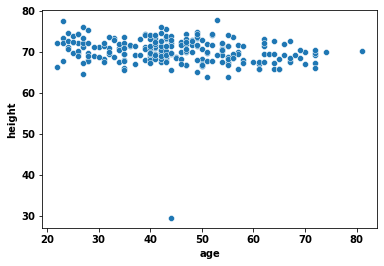

In [5]:
sns.scatterplot(data = df3, x = "age", y = "height");

We note that there is one outlier where a person is slightly less than 29.5 inches tall. While there are a extraordinarily small number of adult males who are less than three feet tall, reflection on the rest of the data from this observation suggest that this was simply an error.

In [6]:
df3.query("height < 40")

,% fat,density,age,weight,height,neck,chest,abdomen
41,32.9,1.025,44,205.0,29.5,36.6,106.0,104.3


In [7]:
df3 = df3.drop(41)

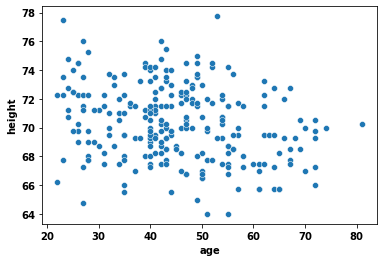

In [8]:
sns.scatterplot(data = df3, x = "age", y = "height");

We can try to visualize more than 2 attributes at once, but the relationships displayed in e.g. the color and dot size space are much harder for human readers to see. For example, above we saw that density and % fat are almost entirely redundant, but this relationship is impossible to see when comparing the colors and dot sizes.

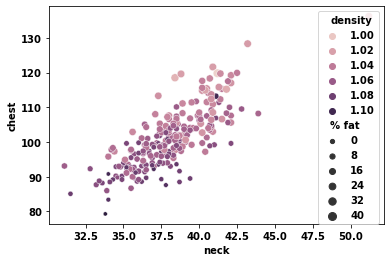

In [9]:
sns.scatterplot(data = df3, x = "neck", y = "chest", hue="density", size = "% fat");

Seaborn gives us the ability to create a matrix of all possible pairs of variables. This is can be useful, though even with only 8 variables it's still difficult to fully digest.

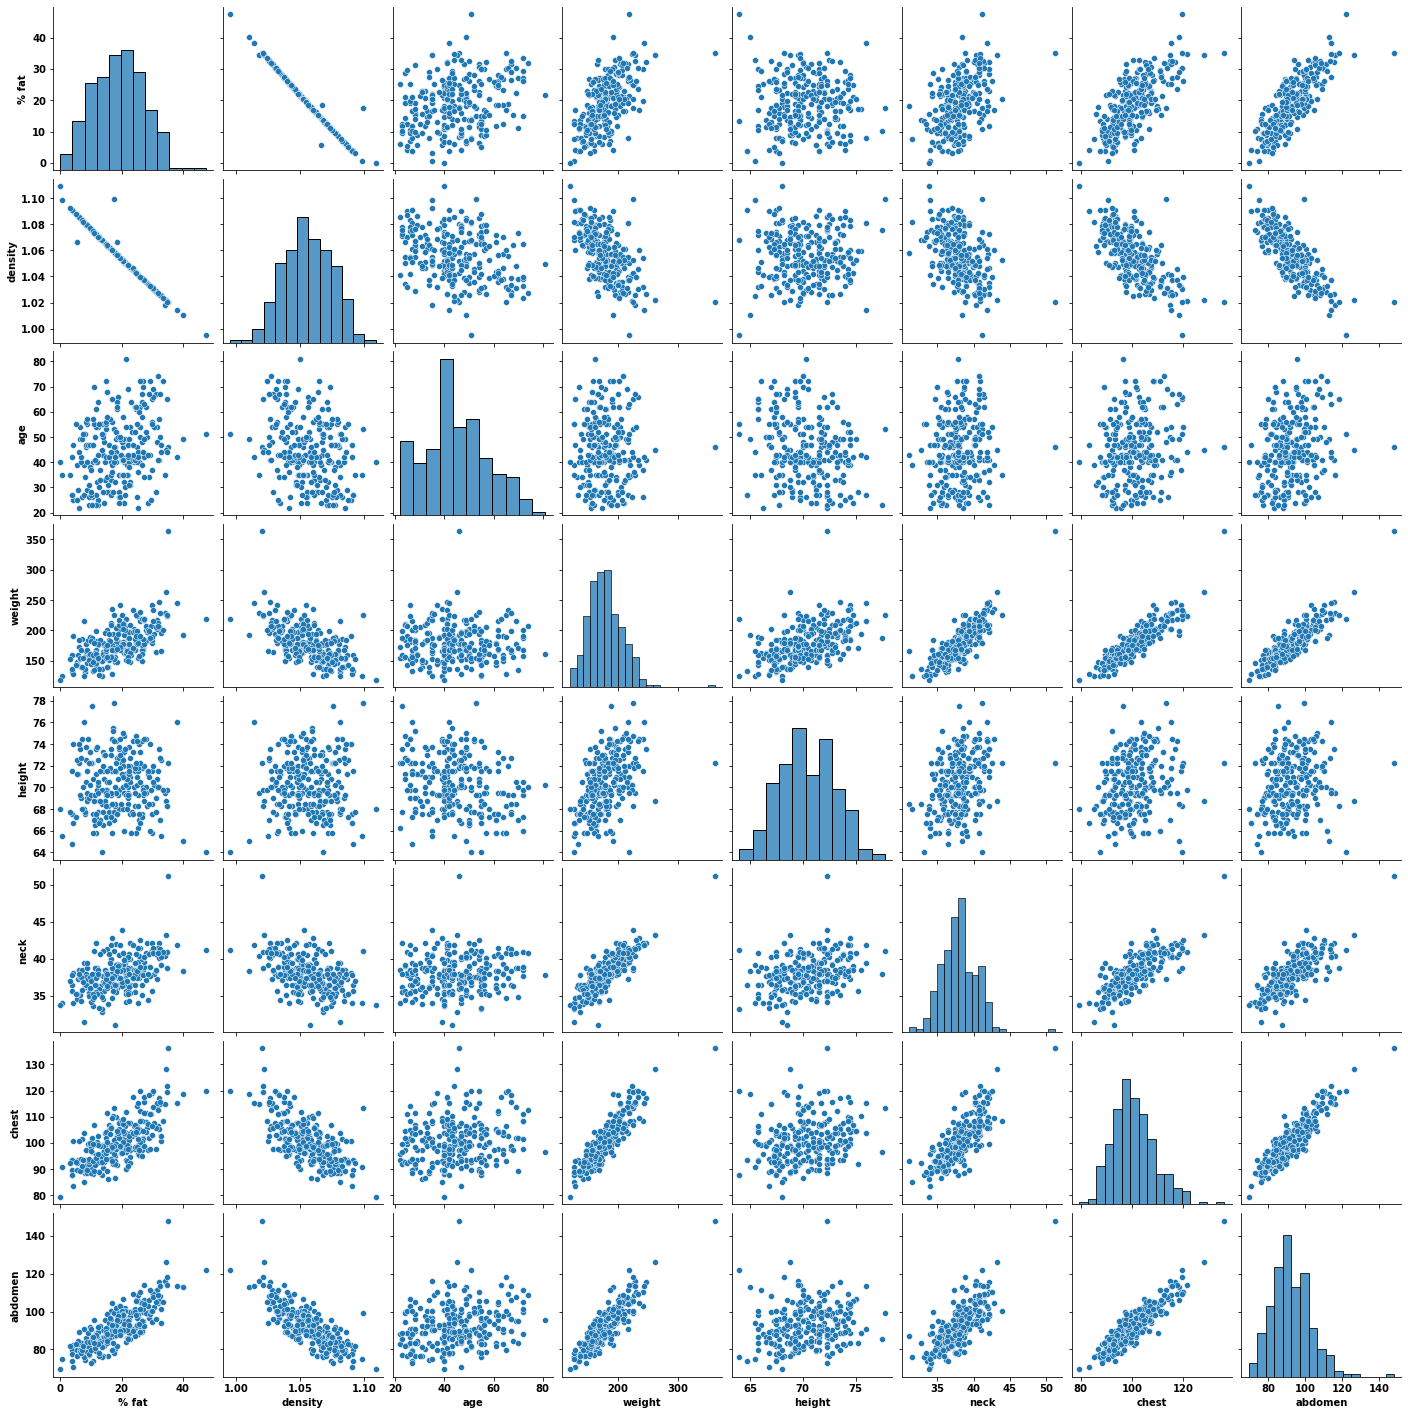

In [10]:
sns.pairplot(df3);

We should note that despite the very strong relationship between % fat and density, the numerical rank of the data matrix is still 8. For the rank to be 7, we'd need the data to be almost exactly on a line. We'll talk about techniques to reduce the dimensionality over the course of this lecture and the next.

In [11]:
np.linalg.matrix_rank(df3)

8

## House of Representatives Voting Data

Next, let's consider voting data from the house of representatives in the U.S. during the month of September 2019. In this example, our goal will be to try to find clusters of representatives who vote in similar ways. For example, we might expect to find that Democrats and Republicans vote similarly to other members of their party.

In [12]:
from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [13]:
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Using cached version that was downloaded (UTC): Mon Dec 27 06:04:40 2021


<ipython-input-13-b7773bf4bf7f>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  legislators_data = yaml.load(open(f))


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [14]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('data/votes.csv')
votes = votes.astype({"roll call": str}) 
votes.head()

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [15]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,vote,leg_id,first,last,gender,state,chamber_y,party,birthday
17414,House,1,532,P000197,Speaker,P000197,Nancy,Pelosi,F,CA,rep,Democrat,1940-03-26
15259,House,1,555,T000472,Yes,T000472,Mark,Takano,M,CA,rep,Democrat,1960-12-10
15638,House,1,545,T000481,No,T000481,Rashida,Tlaib,F,MI,rep,Democrat,1976-07-24
14655,House,1,544,S001199,Yes,S001199,Lloyd,Smucker,M,PA,rep,Republican,1964-01-23
5238,House,1,548,F000462,Yes,F000462,Lois,Frankel,F,FL,rep,Democrat,1948-05-16


In [16]:
def was_yes(s):
    if s.iloc[0] == 'Yes':
        return 1
    else:
        return 0

In [17]:
vote_pivot = votes.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=was_yes, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


In [18]:
vote_pivot.shape

(441, 41)

This data has 441 observations (members of the House of Representatives including the 6 non-voting representatives) and 41 dimensions (votes). While politics is quite polarized, none of these columns are linearly dependent as we note below.

In [19]:
np.linalg.matrix_rank(vote_pivot)

41

Suppose we want to find clusters of similar voting behavior. We might try by reducing our data to only two dimensions and looking to see if we can identify clear patterns. Let's start by looking at what votes were most controversial.

In [20]:
np.var(vote_pivot, axis=0).sort_values(ascending = False)

roll call
555    0.249988
530    0.249896
540    0.249896
542    0.249783
537    0.249783
543    0.249711
536    0.249711
534    0.249711
533    0.249711
550    0.249628
552    0.249536
546    0.249536
549    0.249536
518    0.249433
547    0.249320
517    0.249320
545    0.249063
553    0.248765
525    0.248425
551    0.248240
531    0.247397
524    0.246389
526    0.246111
521    0.246111
529    0.244898
528    0.244230
527    0.243150
520    0.242378
523    0.241144
522    0.231796
539    0.231796
516    0.221461
538    0.216679
544    0.198066
515    0.112546
541    0.095218
554    0.078743
532    0.071153
535    0.051460
519    0.047398
548    0.043295
dtype: float64

We see that roll call 548 had very little variance. According to [http://clerk.house.gov/evs/2019/roll548.xml](http://clerk.house.gov/evs/2019/roll548.xml), this bill was referring to the 2019 Whistleblower Complaint about President Trump and Ukraine. The full text of the house resolution for this roll call can be found at [https://www.congress.gov/bill/116th-congress/house-resolution/576/text](https://www.congress.gov/bill/116th-congress/house-resolution/576/text):

(1) the whistleblower complaint received on August 12, 2019, by the Inspector General of the Intelligence Community shall be transmitted immediately to the Select Committee on Intelligence of the Senate and the Permanent Select Committee on Intelligence of the House of Representatives; and

(2) the Select Committee on Intelligence of the Senate and the Permanent Select Committee on Intelligence of the House of Representatives should be allowed to evaluate the complaint in a deliberate and bipartisan manner consistent with applicable statutes and processes in order to safeguard classified and sensitive information.

We see that 421 congresspeople voted for this resolution, and 12 did not vote for this resolution. 2 members answered "present" but did not vote no, and 10 did not vote at all. Clearly, a scatterplot involving this particular dimension isn't going to be useful.

In [21]:
vote_pivot['548'].value_counts()

1    421
0     20
Name: 548, dtype: int64

By contrast, we saw high variance for most of the other roll call votes. Most them had variances near 0.25, which is the maximum possible for a variable which can take on values 0 or 1. Let's consider the two highest variance variables, shown below:

In [22]:
vote_pivot['555'].value_counts()

1    222
0    219
Name: 555, dtype: int64

In [23]:
vote_pivot['530'].value_counts()

1    225
0    216
Name: 530, dtype: int64

Let's use these as our two dimensions for our scatterplot and see what happens.

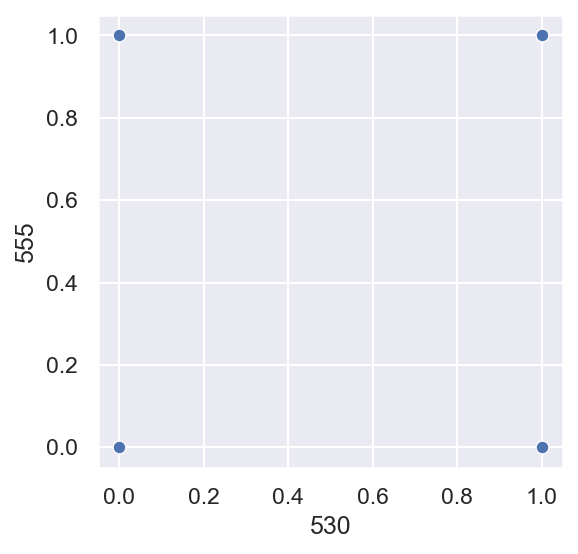

In [24]:
sns.scatterplot(x='530', y='555', data=vote_pivot);

By adding some random noise, we can get rid of the overplotting.

In [25]:
vote_pivot_jittered = vote_pivot.copy()
vote_pivot_jittered.loc[:, '515':'555'] += np.random.random(vote_pivot_jittered.loc[:, '515':'555'].shape) * 0.3

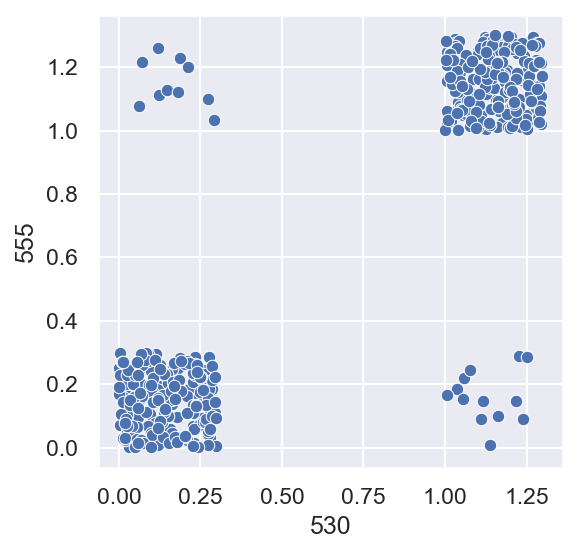

In [26]:
sns.scatterplot(x='530', y='555', data=vote_pivot_jittered);

We can also look at this data labeled by party.

In [27]:
vote_pivot_labeled = vote_pivot.reset_index().merge(legs, left_on='member', right_on='leg_id').set_index('member')
vote_pivot_labeled.head(5)

,515,516,517,518,519,520,521,522,523,524,...,554,555,leg_id,first,last,gender,state,chamber,party,birthday
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,1,0,A000055,Robert,Aderholt,M,AL,rep,Republican,1965-07-22
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,A000367,Justin,Amash,M,MI,rep,Libertarian,1980-04-18
A000369,1,1,0,0,1,1,0,1,1,1,...,1,0,A000369,Mark,Amodei,M,NV,rep,Republican,1958-06-12
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,A000370,Alma,Adams,F,NC,rep,Democrat,1946-05-27
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,A000371,Pete,Aguilar,M,CA,rep,Democrat,1979-06-19


In [28]:
vote_pivot_labeled_jittered = vote_pivot_labeled.copy()
vote_pivot_labeled_jittered.loc[:, '515':'555'] += np.random.random(vote_pivot_labeled_jittered.loc[:, '515':'555'].shape) * 0.3

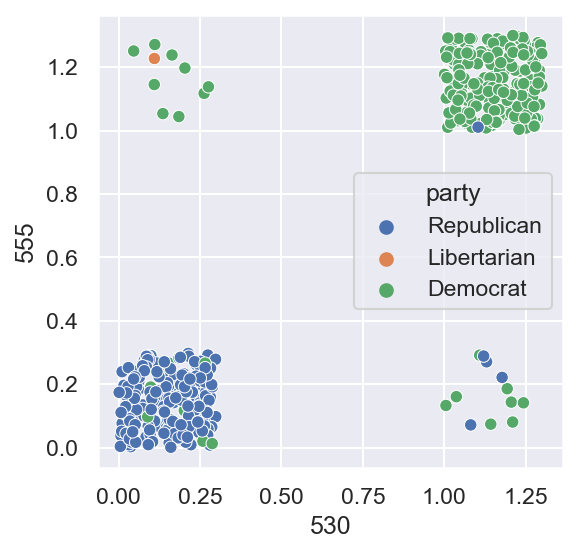

In [29]:
sns.scatterplot(x='530', y='555', data=vote_pivot_labeled_jittered, hue="party");

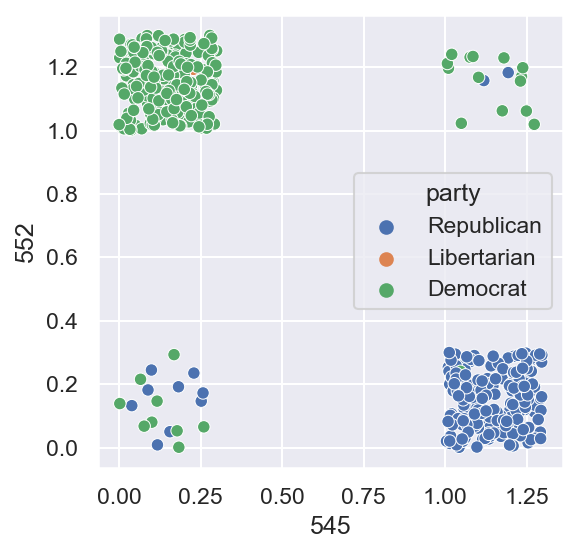

In [30]:
sns.scatterplot(x='545', y='552', data=vote_pivot_labeled_jittered, hue="party");

We see that considering only two votes does seem to do a pretty good job of telling Republicans from Democrats. We'll see later in this lecture how we can do even better using a technique called "Principle Component Analysis" or PCA.

Before we can get there, we'll need to spend some time reviewing key linear algebra principles.

## Matrix Operations in Python

In [31]:
age_and_height = np.array([[182, 28], [399, 30], [725, 33]])

In [32]:
M = np.array([[1, 0, 0], [0, 1, 1/12]])

In [33]:
age_and_height @ M

array([[182.        ,  28.        ,   2.33333333],
       [399.        ,  30.        ,   2.5       ],
       [725.        ,  33.        ,   2.75      ]])

## Singular Value Decomposition Experiment

### Manual Decomposition

In the table below, we have the width, height, area, and perimeter of a rectangle stored in a dataframe.

In [34]:
rectangle = pd.read_csv("data/rectangle_data.csv")
rectangle.head(5)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34


Naturally the perimeter is just the sum of 2x the width and 2x the height. Thus, if we create a new dataframe that has only the width, height, and area...

In [35]:
rectangle_no_perim = rectangle[["width", "height", "area"]]
rectangle_no_perim.head(5)

,width,height,area
0,8,6,48
1,2,4,8
2,1,3,3
3,9,3,27
4,9,8,72


... then we can recover the perimeter by multiplying this matrix by

`1   0   0   2
0   1   0   2
0   0   1   0`

In [36]:
transform_3D_to_4D = [[1, 0, 0, 2], [0, 1, 0, 2], [0, 0, 1, 0]]

In [37]:
rectangle_with_perimeter_back = np.array(rectangle_no_perim) @ transform_3D_to_4D
pd.DataFrame(rectangle_with_perimeter_back, columns = ["width", "height", "area", "perimeter"]).head(5)

,width,height,area,perimeter
0,8,6,48,28
1,2,4,8,12
2,1,3,3,8
3,9,3,27,24
4,9,8,72,34


### Singular Value Decomposition Example

Singular value decomposition is a numerical technique to (among other things) automatically uncover such redundancies. Given an input matrix X, SVD will return $U\Sigma$ and $V^T$ such that $ X = U \Sigma V^T $.

In [38]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)

As we did before with our manual decomposition, we can recover our original rectangle data by multiplying the three return values of this function back together.

In [39]:
pd.DataFrame(u * s @ vt).head(4)

,0,1,2,3
0,8.0,6.0,48.0,28.0
1,2.0,4.0,8.0,12.0
2,1.0,3.0,3.0,8.0
3,9.0,3.0,27.0,24.0


The two key pieces of the decomposition are $U\Sigma$ and $V^T$, which we can think of for now as analogous to our 'data' and 'transformation operation' from our manual decomposition earlier.

Let's start by looking at $U\Sigma$, which we can compute with the Python code `u*s`.

In [40]:
u*s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

Similarly, we can look at vt.

In [41]:
vt

array([[-1.46435746e-01, -1.29942186e-01, -8.10020095e-01,
        -5.52755864e-01],
       [-1.92735898e-01, -1.89127741e-01,  5.86348204e-01,
        -7.63727278e-01],
       [-7.04957447e-01,  7.09155330e-01,  7.95161387e-03,
         8.39576575e-03],
       [-6.66666667e-01, -6.66666667e-01, -1.08794322e-16,
         3.33333333e-01]])

The automatic decomposition returned by the svd function looks quite different than what we got when we manually decomposed our data into "data" and "operations". That is, vt is a bunch of seemingly arbitrary numbers instead of the rather simple:

`1   0   0   2
0   1   0   2
0   0   1   0`

Similarly, if we look at the shape of $U\Sigma$ and $V^T$ we see that they are bigger than in our manual decomposition. Specifically $U\Sigma$ still has 4 columns, meaning that each observation is 4 dimensional. Furthermore, rather than our transformation operation $V^T$ being 3x4, it's 4x4 rows tall, meaning that it maps 4 dimensional inputs back to 4 dimensions.

This seems problematic, because our goal of using SVD was to find a transformation operation that takes 3D inputs and maps them up to 4 dimensions.

Luckily, if we look carefully at $U\Sigma$, we see that the last attribute of each observation is very close to 0. 

In [42]:
u * s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

Thus, it makes sense that we remove the last column of $U \Sigma$. 

In [43]:
u = u[:, 0:3]
s = s[0:3]
u * s

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00],
       [-4.08780385e+01, -1.86471027e+00, -2.34708823e+00],
       [-5.34289549e+00, -3.98065864e+00,  7.79631035e-01],
       [-2.82033419e+01, -8.33535389e+00,  5.30031897e+00],
       [-6.40083890e+01,  7.06150790e+00,  1.43570386e+00],
       [-4.32916052e+01, -1.02057499e-01

Similarly, because the observations are now 3D, we should remove the last row of $V^T$, since we want to use $V^T$ to map our now 3D data into 4D (rather than expecting 4D input data).

In [44]:
vt = vt[0:3, :]

After removing the redundant portions of $U\Sigma$ and $V^T$, we can verify that multiplying them together again yields our original array.

In [45]:
u * s @ vt

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.],
       [ 3.,  1.,  3.,  8.],
       [ 4.,  2.,  8., 12.],
       [ 6.,  5., 30., 22.],
       [ 7.,  1.,  7., 16.],
       [ 8.,  2., 16., 20.],
       [ 5.,  5., 25., 20.],
       [ 9.,  5., 45., 28.],
       [ 8.,  4., 32., 24.],
       [ 1.,  2.,  2.,  6.],
       [ 2.,  9., 18., 22.],
       [ 7.,  8., 56., 30.],
       [ 7.,  5., 35., 24.],
       [ 2.,  4.,  8., 12.],
       [ 2.,  5., 10., 14.],
       [ 4.,  3., 12., 14.],
       [ 8.,  1.,  8., 18.],
       [ 8.,  5., 40., 26.],
       [ 9.,  8., 72., 34.],
       [ 7.,  3., 21., 20.],
       [ 8.,  3., 24., 22.],
       [ 6.,  6., 36., 24.],
       [ 6.,  4., 24., 20.],
       [ 8.,  4., 32., 24.],
       [ 7.,  2., 14., 18.],
       [ 4.,  4., 16., 16.],
       [ 4.,  1.,  4., 10.],
       [ 9.,  7., 63., 32.],
       [ 4.,  2.,  8., 12.],
       [ 1.,  2.,  2.,  6.],
       [ 8.,  

## Singular Value Decomposition Experiment

The reasons that $U \Sigma$ and $V^T$ look so different than the results of our manual decomposition are a consequence of how singular value decomposition. Specifically, given X, SVD computers $U$, $\Sigma$, and $V$ such that:
1. $\Sigma$ is a diagonal matrix containing the singular values of X.
2. $U$ and $V$ are matrices whose columns form an orthonormal set.
3. $X = U \Sigma V^T$

That is, there are an infinite number of matrices such that $X = AB$. In our example above, we created A and B through manual calculation and insight (recognizing that perimeter was 2*w + 2*h). SVD computes them automatically, and the results have the specific properties enumerated above.

In [46]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)

### The Singular Values Matrix $\Sigma$

The middle result returned by the SVD process is a diagonal matrix consisting of the singular values. We won't say a lot about what they mean today, but we will note that if the matrix is of rank r, then the first r singular values will be non-zero, and the rest will be zero.

In [47]:
s

array([3.62932568e+02, 6.29904732e+01, 2.56544651e+01, 4.29718368e-15])

Python returns the singular values in a slightly funny format (as a list). To get them into the correct form, we can use `diag(s)`.

In [48]:
np.diag(s)

array([[3.62932568e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.29904732e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.56544651e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.29718368e-15]])

If we do this, then we can compute the original matrix using only the matrix multiplication operator. That is, rather than writing `u * s @ vt`, we can do `u @ np.diag(s) @ vt`.

In [49]:
(u @ np.diag(s) @ vt)[0:5, :]

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.]])

The fact that the last singular value is zero is why we were able to remove the last dimension of $U$ and the last operation in $V^T$. That is, since the last column of $U \Sigma$ is always zero, we can just remove it completely.

In [50]:
(u @ np.diag(s))

array([[-5.63092679e+01,  4.08369641e+00, -7.67968689e-01,
         1.83452516e-15],
       [-1.39258714e+01, -5.61592446e+00,  1.59106852e+00,
        -3.36581235e-15],
       [-7.38836950e+00, -5.11089273e+00,  1.51352951e+00,
        -7.04453569e-17],
       [-3.68444316e+01, -4.80005945e+00, -3.80095908e+00,
        -2.03741937e-16],
       [-7.94726055e+01,  1.30026983e+01,  1.86597851e-01,
        -2.66709514e-16],
       [-7.42135662e+00, -5.11810904e+00, -1.31469604e+00,
         7.80250388e-17],
       [-1.39588585e+01, -5.62314077e+00, -1.23715703e+00,
         5.55717762e-17],
       [-3.79895573e+01, -1.31360807e+00, -2.60712770e-01,
         3.01043718e-16],
       [-1.56692269e+01, -9.65347804e+00, -4.03555325e+00,
         3.52041495e-16],
       [-2.54468092e+01, -7.81311695e+00, -3.92620778e+00,
        -8.48509568e-17],
       [-3.26875093e+01, -2.52515864e+00,  3.87695076e-01,
        -1.26500289e-16],
       [-5.38957011e+01,  2.32104364e+00, -2.20593631e+00,
      

In [51]:
(u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :])[0:5, :]

array([[ 8.,  6., 48., 28.],
       [ 2.,  4.,  8., 12.],
       [ 1.,  3.,  3.,  8.],
       [ 9.,  3., 27., 24.],
       [ 9.,  8., 72., 34.]])

### $U$ and $V^T$

Let's try verifying that $U$ is orthonormal. If so, any column dot producted with itself should be 1, and any columns dot producted with any other should be zero.

In [52]:
np.dot(u[:, 0], u[:, 0])

1.0000000000000009

In [53]:
np.dot(u[:, 1], u[:, 1])

1.000000000000001

In [54]:
np.dot(u[:, 2], u[:, 2])

1.0

In [55]:
for i in range(0, u.shape[1]):
    print(f"row {i} dot producted with itself is {np.dot(u[:, i], u[:, i])}")

row 0 dot producted with itself is 1.0000000000000009
row 1 dot producted with itself is 1.000000000000001
row 2 dot producted with itself is 1.0
row 3 dot producted with itself is 0.9999999999999997


In [56]:
for i in range(0, u.shape[1]):
    for j in range(i + 1, u.shape[1]):
        print(f"row {i} dot producted with {j} is {np.dot(u[:, i], u[:, j])}")

row 0 dot producted with 1 is 6.938893903907228e-17
row 0 dot producted with 2 is -1.5959455978986625e-16
row 0 dot producted with 3 is -2.0816681711721685e-17
row 1 dot producted with 2 is -1.6653345369377348e-16
row 1 dot producted with 3 is -5.551115123125783e-17
row 2 dot producted with 3 is 1.942890293094024e-16


Let's now look at $V$.

In [57]:
v = vt.T

In [58]:
for i in range(0, v.shape[1]):
    print(f"row {i} of V dot producted with itself is {np.dot(v[:, i], v[:, i])}")

row 0 of V dot producted with itself is 0.9999999999999999
row 1 of V dot producted with itself is 0.9999999999999991
row 2 of V dot producted with itself is 0.9999999999999994
row 3 of V dot producted with itself is 0.9999999999999997


In [59]:
for i in range(0, v.shape[1]):
    for j in range(i + 1, v.shape[1]):
        print(f"row {i} of V dot producted with {j} is {np.dot(v[:, i], v[:, j])}")

row 0 of V dot producted with 1 is -1.1102230246251565e-16
row 0 of V dot producted with 2 is -2.7755575615628914e-17
row 0 of V dot producted with 3 is 8.326672684688674e-17
row 1 of V dot producted with 2 is -3.0531133177191805e-16
row 1 of V dot producted with 3 is 1.3877787807814457e-16
row 2 of V dot producted with 3 is -1.1102230246251565e-16


We can also see that the transpose of u (and v) is also the inverse of u (and v).

In [60]:
u.T @ u

array([[ 1.00000000e+00,  6.08780055e-17, -1.26070207e-16,
         2.60600768e-17],
       [ 6.08780055e-17,  1.00000000e+00, -8.42618413e-17,
        -4.55589337e-17],
       [-1.26070207e-16, -8.42618413e-17,  1.00000000e+00,
         1.85468183e-16],
       [ 2.60600768e-17, -4.55589337e-17,  1.85468183e-16,
         1.00000000e+00]])

In [61]:
v.T @ v

array([[ 1.00000000e+00, -1.19401155e-16, -1.85206167e-17,
         7.49910479e-17],
       [-1.19401155e-16,  1.00000000e+00, -3.01503764e-16,
         8.81466618e-17],
       [-1.85206167e-17, -3.01503764e-16,  1.00000000e+00,
        -9.61433852e-17],
       [ 7.49910479e-17,  8.81466618e-17, -9.61433852e-17,
         1.00000000e+00]])

## Low Rank Approximations of Rectangle Data

This section was not covered in lecture but may add additional context.

In [62]:
colnames = list(rectangle.columns)

Suppose we our area and perimeter measurements are slightly noisy.

In [63]:
rectangle_noisy = rectangle.copy()
rectangle_noisy["perimeter"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["perimeter"]))
rectangle_noisy["area"] += np.random.normal(loc = 0, scale = 0.01, size = len(rectangle_noisy["area"]))
rectangle_noisy.head(5)

,width,height,area,perimeter
0,8,6,48.007859,27.997381
1,2,4,7.992049,11.998469
2,1,3,2.993586,8.028321
3,9,3,27.001908,24.007669
4,9,8,71.997434,33.996574


In [64]:
u, s, vt = np.linalg.svd(rectangle_noisy, full_matrices = False)

Even on this noisy data, we can recover the exact measurements by multiplying $U \Sigma V^T$.

In [65]:
vt

array([[-1.46440217e-01, -1.29947414e-01, -8.10018522e-01,
        -5.52755757e-01],
       [-1.92722329e-01, -1.89103533e-01,  5.86350444e-01,
        -7.63734977e-01],
       [-7.04973937e-01,  7.09138820e-01,  7.94674525e-03,
         8.41016906e-03],
       [ 6.66652169e-01,  6.66690076e-01, -2.13253202e-05,
        -3.33315508e-01]])

In [66]:
pd.DataFrame((u @ np.diag(s) @ vt)[0:5, :]).head(5)

,0,1,2,3
0,8.0,6.0,48.007859,27.997381
1,2.0,4.0,7.992049,11.998469
2,1.0,3.0,2.993586,8.028321
3,9.0,3.0,27.001908,24.007669
4,9.0,8.0,71.997434,33.996574


Let's take a look at the singular values:

In [67]:
s

array([3.62920297e+02, 6.29952089e+01, 2.56545181e+01, 3.26547402e-02])

Despite not being zero, we can nevertheless again eliminate the last column (dimension) of $U$, last singular value from $\Sigma$ and last row (operation) from $V^T$. We see that we get back reasonable answers, though they're a little off.

In [68]:
pd.DataFrame((u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,7.999752,5.999752,48.007859,27.997506
1,1.999588,3.999588,7.992049,11.998675
2,1.006203,3.006204,2.993586,8.025219
3,9.001843,3.001843,27.001908,24.006747
4,8.999820,7.999820,71.997434,33.996664


This is what is known as a "low rank approximation" of the data. Specifically, this is a rank 3 approximation since we're using 3 of the available 4 dimensions. Since the noise was small, this rank 3 approximation is good. 

As a warmup to the rest of lecture, let's see what the rank 2 approximation looks like. 

Note: In the code below, I've specified which rows/columns that I do want rather than the ones I don't want. That is, instead of writing `u[:, :-2]`, I've written `u[:, 0:2]`.

In [69]:
pd.DataFrame((u[:, 0:2] @ np.diag(s[0:2]) @ vt[0:2, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,7.458339,6.544363,48.013962,28.003964
1,3.121221,2.871329,7.979405,11.985295
2,2.073359,1.932744,2.981556,8.012488
3,6.322333,5.697183,27.032112,24.038713
4,9.131233,7.867632,71.995953,33.995096


This code is getting a little hard to read, so let's write a function that computes the rank k approximation of a given DataFrame.

In [70]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

pd.DataFrame(compute_rank_k_approximation(rectangle_noisy, 2)).head(5)

,width,height,area,perimeter
0,7.458339,6.544363,48.013962,28.003964
1,3.121221,2.871329,7.979405,11.985295
2,2.073359,1.932744,2.981556,8.012488
3,6.322333,5.697183,27.032112,24.038713
4,9.131233,7.867632,71.995953,33.995096


We can even look at the rank 1 approximation. 

In [71]:
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.246660,7.317881,45.615525,31.127984
1,2.038243,1.808686,11.274324,7.693587
2,1.083488,0.961461,5.993200,4.089753
3,5.396355,4.788592,29.849366,20.369175
4,11.637399,10.326739,64.371036,43.926725


In effect, what the SVD process has done is figured out a way to rebuild an approximation of our entire 4D matrix using only 1 column of data. This might seem somewhat shocking.

In [72]:
pd.DataFrame((u[:, 0:1] @ np.diag(s[0:1]) @ vt[0:1, :]),
            columns = colnames).head(5)

,width,height,area,perimeter
0,8.246660,7.317881,45.615525,31.127984
1,2.038243,1.808686,11.274324,7.693587
2,1.083488,0.961461,5.993200,4.089753
3,5.396355,4.788592,29.849366,20.369175
4,11.637399,10.326739,64.371036,43.926725


In [73]:
u, s, vt = np.linalg.svd(rectangle, full_matrices = False)
compute_rank_k_approximation(rectangle_noisy, 1).head(5)

,width,height,area,perimeter
0,8.246660,7.317881,45.615525,31.127984
1,2.038243,1.808686,11.274324,7.693587
2,1.083488,0.961461,5.993200,4.089753
3,5.396355,4.788592,29.849366,20.369175
4,11.637399,10.326739,64.371036,43.926725


In [74]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

## Rank 1 Approximation of 2D Data, Data Centering

In [75]:
# Downloads from https://www.gapminder.org/data/
cm_path = 'data/child_mortality_0_5_year_olds_dying_per_1000_born.csv'
fe_path = 'data/children_per_woman_total_fertility.csv'
cm = pd.read_csv(cm_path).set_index('country')['2017'].to_frame()/10
fe = pd.read_csv(fe_path).set_index('country')['2017'].to_frame()
child_data = cm.merge(fe, left_index=True, right_index=True).dropna()
child_data.columns = ['mortality', 'fertility']
child_data.head()

,mortality,fertility
country,,
Afghanistan,6.820,4.48
Albania,1.330,1.71
Algeria,2.390,2.71
Angola,8.310,5.62
Antigua and Barbuda,0.816,2.04


C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


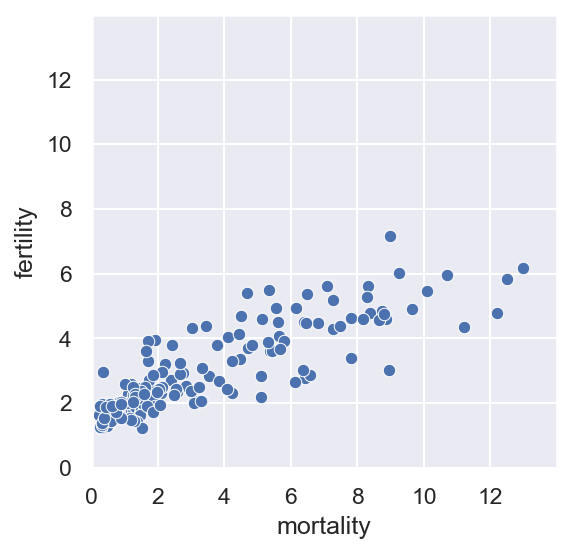

In [76]:
def scatter14(data):
    sns.scatterplot('mortality', 'fertility', data=data)
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.xticks(np.arange(0, 14, 2))
    plt.yticks(np.arange(0, 14, 2))    
    
scatter14(child_data)

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mortality', ylabel='fertility'>

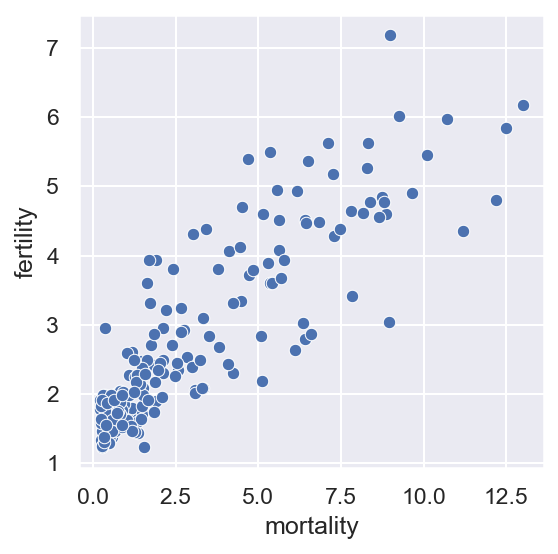

In [77]:
sns.scatterplot('mortality', 'fertility', data=child_data)

In [78]:
u, s, vt = np.linalg.svd(child_data, full_matrices = False)

In [79]:
child_data_reconstructed = pd.DataFrame(u @ np.diag(s) @ vt, columns = ["mortality", "fertility"], index=child_data.index)

As we'd expect, the product of $U$, $\Sigma$, and $V^T$ recovers the original data perfectly.

In [80]:
child_data_reconstructed.head(5)

,mortality,fertility
country,,
Afghanistan,6.820,4.48
Albania,1.330,1.71
Algeria,2.390,2.71
Angola,8.310,5.62
Antigua and Barbuda,0.816,2.04


C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mortality', ylabel='fertility'>

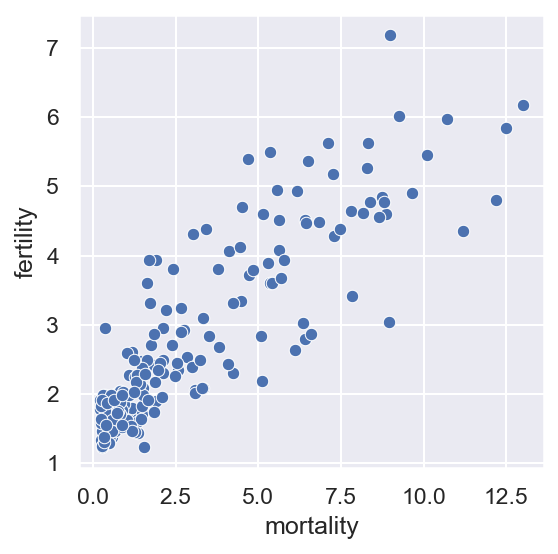

In [81]:
sns.scatterplot('mortality', 'fertility', data=child_data)

What happens if we throw away a column of $U$, a singular value from $\Sigma$, and a row from $V^T$? In this case we end up with the "rank 1 approximation" of the data.

Looking at the data, we see that it does a surprisingly good job.

In [82]:
#child_data_rank_1_approximation = pd.DataFrame(u[:, :-1] @ np.diag(s[:-1]) @ vt[:-1, :], columns = ["mortality", "fertility"], index=child_data.index)

child_data_rank_1_approximation = compute_rank_k_approximation(child_data, 1)
child_data_rank_1_approximation.head(5)

,mortality,fertility
0,6.694067,4.660869
1,1.697627,1.182004
2,2.880467,2.005579
3,8.232160,5.731795
4,1.506198,1.048719


By plotting the data in a 2D space, we can see what's going on. We're simply getting the original data projected on to some 1 dimensional subspace.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mortality', ylabel='fertility'>

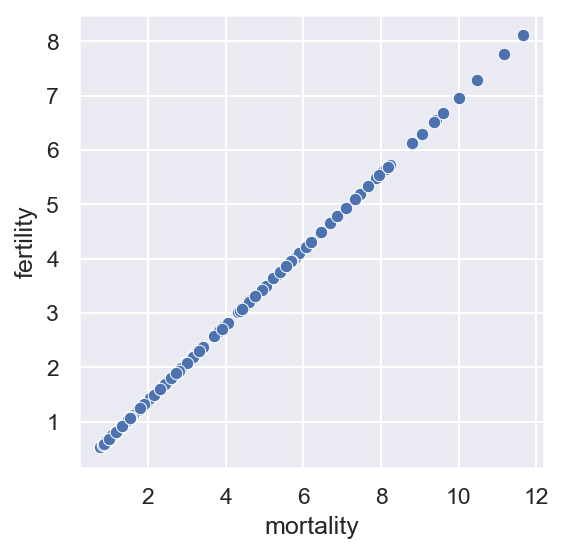

In [83]:
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)

There's one significant issue with our projection, which we can see by plotting both the original data and our reconstruction on the same axis. The issue is that the projection goes through the origin but our data has a non-zero y-intercept.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mortality', ylabel='fertility'>

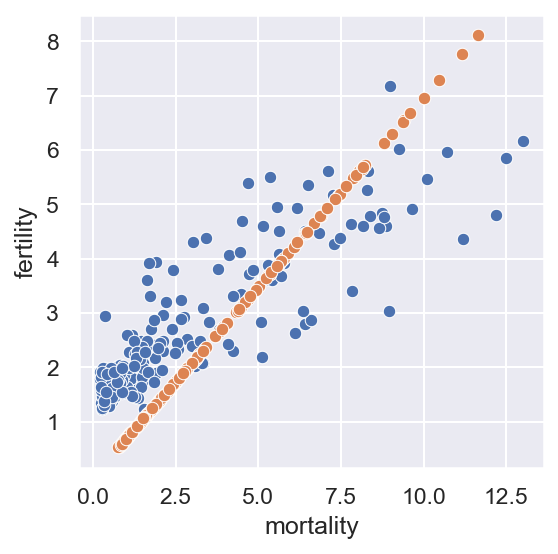

In [84]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)

While this y-intercept misalignment isn't terrible here, it can be really bad. For example, consider the 2D dataset below (from our body measurements dataset from the previous lecture).

In [85]:
#http://jse.amstat.org/datasets/fat.txt
body_data = pd.read_fwf("data/fat.dat.txt", colspecs = [(9, 13), (17, 21), (23, 29), (35, 37),
                                             (39, 45), (48, 53), (57, 61), (64, 69),
                                             (73, 77), (80, 85), (88, 93), (96, 101),
                                             (105, 109), (113, 117), (121, 125), (129, 133),
                                             (137, 141), (145, 149)], 
                  
                  
                  header=None, names = ["% brozek fat", "% siri fat", "density", "age", 
                                       "weight", "height", "adiposity", "fat free weight",
                                       "neck", "chest", "abdomen", "hip", "thigh",
                                       "knee", "ankle", "bicep", "forearm",
                                       "wrist"])
#body_data = body_data.drop(41) #drop the weird record
body_data.head()

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [86]:
density_and_abdomen = body_data[["density", "abdomen"]]
density_and_abdomen.head(5)

,density,abdomen
0,1.0708,85.2
1,1.0853,83.0
2,1.0414,87.9
3,1.0751,86.4
4,1.0340,100.0


If we look at the data, the rank 1 approximation looks at least vaguely sane from the table. 

In [87]:
density_and_abdomen_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen, 1)
density_and_abdomen_rank_1_approximation.head(5)

,density,abdomen
0,0.957134,85.201277
1,0.932425,83.001717
2,0.987458,87.900606
3,0.970613,86.401174
4,1.123369,99.998996


But if we plot on 2D axes, we'll see that things are very wrong.

<AxesSubplot:xlabel='density', ylabel='abdomen'>

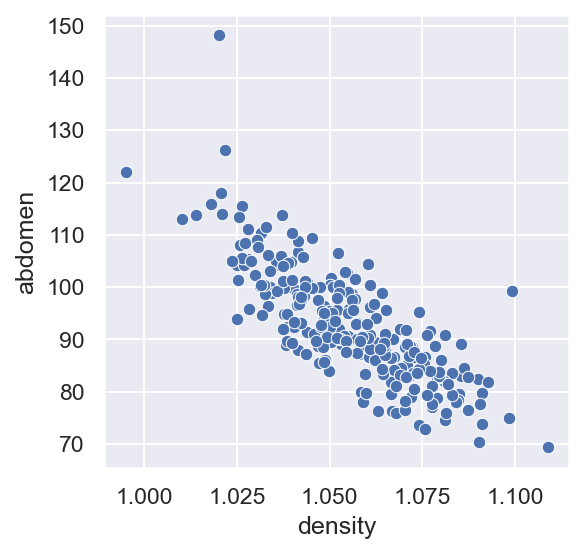

In [88]:
sns.scatterplot(x="density", y="abdomen", data=body_data)

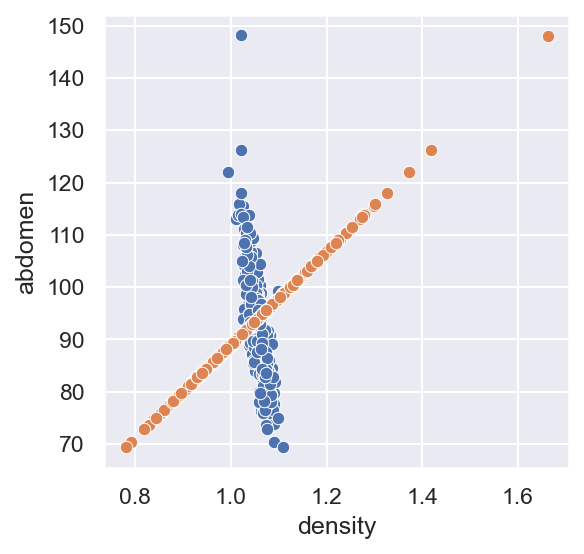

In [89]:
density_and_abdomen_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen, 1)
sns.scatterplot(x="density", y="abdomen", data=body_data)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_rank_1_approximation);

Since the subspace that we're projecting on to is off and to the right, we end up with a bizarre result where our rank 1 approximation believes that density increases with abdomen size, even though the data shows the opposite.

To fix this issue, we should always start the SVD process by zero-centering our data. That is, for each column, we should subtract the mean of that column.

In [90]:
np.mean(density_and_abdomen, axis = 0)

density     1.055574
abdomen    92.555952
dtype: float64

In [91]:
density_and_abdomen_centered = density_and_abdomen - np.mean(density_and_abdomen, axis = 0)
density_and_abdomen_centered.head(5)

,density,abdomen
0,0.015226,-7.355952
1,0.029726,-9.555952
2,-0.014174,-4.655952
3,0.019526,-6.155952
4,-0.021574,7.444048


Now when we do the approximation, things work much better.

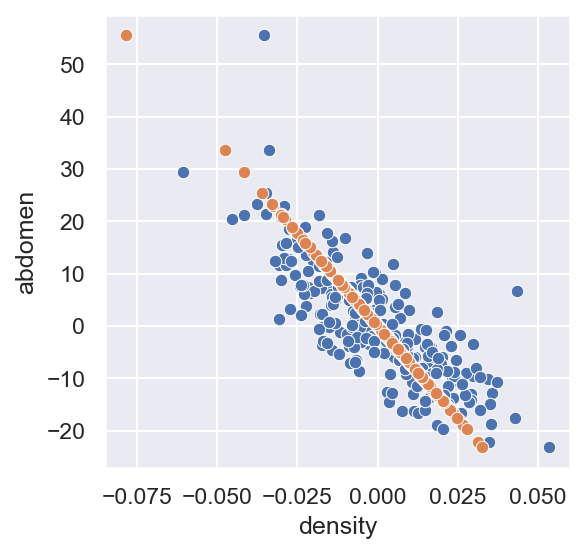

In [92]:
density_and_abdomen_centered_rank_1_approximation = compute_rank_k_approximation(density_and_abdomen_centered, 1)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_centered)
sns.scatterplot(x="density", y="abdomen", data=density_and_abdomen_centered_rank_1_approximation);

### Interpreting Principal Components

Let's revisit our child mortality and maternal fertility data from before.

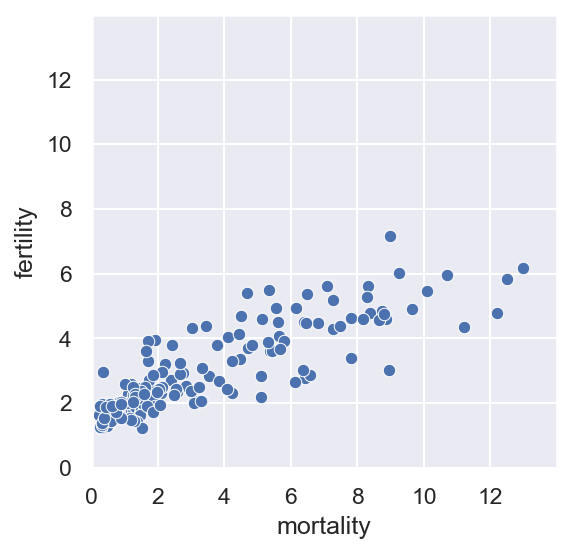

In [93]:
sns.scatterplot(data = child_data, x = "mortality", y= "fertility")
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

Since we're going to be doing SVD, let's make sure to center our data first.

In [94]:
np.mean(child_data, axis = 0)

mortality    3.034590
fertility    2.775956
dtype: float64

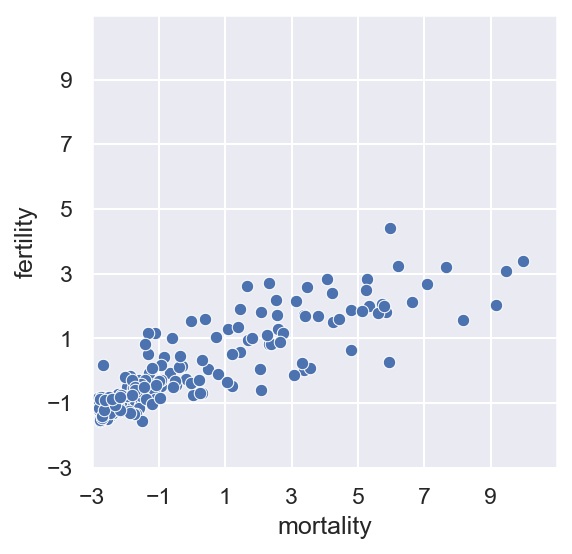

In [95]:
child_means = np.mean(child_data, axis = 0)
child_data_centered = child_data - child_means
sns.scatterplot(data = child_data_centered, x = "mortality", y= "fertility")


plt.xlim([-3, 11])
plt.ylim([-3, 11])
plt.xticks(np.arange(-3, 11, 2))
plt.yticks(np.arange(-3, 11, 2));
# plt.gcf().savefig("mortality_fertility_centered.png", dpi=300, bbox_inches="tight")

## Principal Components and Singular Values

###  Singular Values and Variance

In [96]:
rectangle = pd.read_csv('data/rectangle_data.csv')

In [97]:
rectangle_centered = rectangle - np.mean(rectangle, axis = 0)

In [98]:
np.var(rectangle_centered)

width          7.6891
height         5.3475
area         338.7316
perimeter     50.7904
dtype: float64

In [99]:
sum(np.var(rectangle_centered))

402.5586000000002

In [100]:
u, s, vt = np.linalg.svd(rectangle_centered, full_matrices = False)

In [101]:
u[0:5, :]

array([[-0.1339099 ,  0.00592996,  0.03473374, -0.11961292],
       [ 0.08635418, -0.07951453,  0.01494809,  0.73080748],
       [ 0.11776646, -0.12896256,  0.08577428, -0.06923566],
       [-0.02727392,  0.1831771 ,  0.01089507, -0.06212125],
       [-0.258806  , -0.09429499,  0.09027015, -0.04277946]])

In [102]:
np.diag(s)

array([[1.97388075e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.74346257e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.32626119e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.28199809e-15]])

In [103]:
s**2/rectangle_centered.shape[0]

array([3.89620522e+02, 7.52658687e+00, 5.41149115e+00, 6.85914923e-31])

In [104]:
sum(s**2/rectangle_centered.shape[0])

402.55859999999984

## Practical PCA

Let's now step back and try to use PCA on our body measurement and congressional voting datasets.

In [105]:
body_data.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [106]:
u, s, vt = np.linalg.svd(body_data, full_matrices = False)

We see that some of our principal components capture more variance than others.

In [107]:
s

array([5.02052705e+03, 2.62085056e+02, 2.54543432e+02, 1.41812428e+02,
       5.98783810e+01, 5.29106976e+01, 4.16567900e+01, 3.12823306e+01,
       2.60271725e+01, 2.44919558e+01, 2.21128215e+01, 2.05280695e+01,
       1.86667123e+01, 1.67184654e+01, 1.24277631e+01, 7.79276210e+00,
       1.97067950e+00, 2.72193414e-01])

Or we can compute the fraction of the variance captured by each principal component. The result seems shocking at first, as our data appears to be effectively rank 1.

In [108]:
np.round(s**2 / sum(s**2), 2)

array([0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

This seems absurd, as clearly there are several variables that we expect to be show significant variation independent of each other, e.g. weight, height, and age. If this happens to you, it's probably because you forgot to center your data!

In [109]:
body_data_centered = body_data - np.mean(body_data, axis = 0)
body_data_centered.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,-6.338492,-6.850794,0.015226,-21.884921,-24.674405,-2.39881,-1.736905,-8.813889,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-12.038492,-13.050794,0.029726,-22.884921,-5.674405,2.10119,-2.036905,17.586111,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,5.661508,6.149206,-0.014174,-22.884921,-24.924405,-3.89881,-0.736905,-27.713889,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762
3,-8.038492,-8.750794,0.019526,-18.884921,5.825595,2.10119,-0.536905,20.986111,-0.592063,0.975794,-6.155952,1.295238,0.694048,-1.290476,-0.302381,0.126587,0.736111,-0.029762
4,8.861508,9.549206,-0.021574,-20.884921,5.325595,1.10119,0.163095,-10.613889,-3.592063,-3.524206,7.444048,1.995238,3.794048,3.609524,0.897619,-0.073413,-0.963889,-0.529762


In [110]:
u, s, vt = np.linalg.svd(body_data_centered, full_matrices = False)

This time, we see that the top singular value is no longer as dominant.

In [111]:
s

array([5.86347268e+02, 2.61819089e+02, 1.67113835e+02, 5.99708077e+01,
       5.33302486e+01, 4.22415004e+01, 3.48011060e+01, 2.92855997e+01,
       2.55426169e+01, 2.39181665e+01, 2.08396531e+01, 2.04736098e+01,
       1.85404097e+01, 1.62788697e+01, 1.23779482e+01, 7.72010337e+00,
       1.95363897e+00, 4.48706065e-02])

Looking now at the fraction of the variance captured by each principal component, we see that the top 2 or 3 principal components capture quite a lot of the variance.

In [112]:
np.round(s**2 / sum(s**2), 2)

array([0.76, 0.15, 0.06, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

We can also show this in the form of what is usually called a "scree plot".

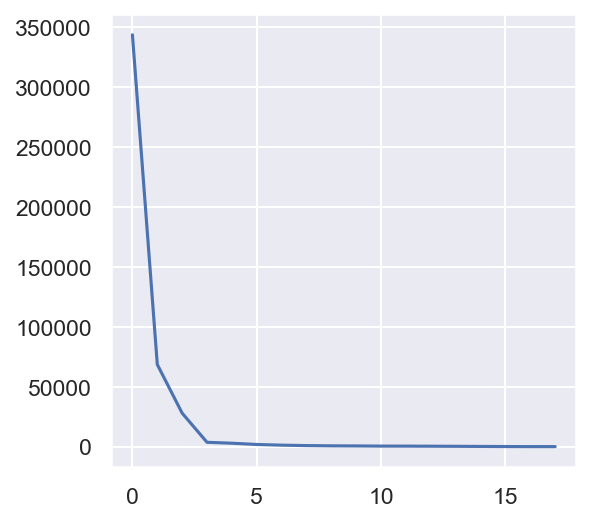

In [113]:
plt.plot(s**2);

Thus, we expect that if we were to do a rank 3 approximation, we should get back data that's pretty close to where we started, as just those 3 dimensions capture 97% of the variance.

In [114]:
body_data_rank_3_approximation = compute_rank_k_approximation(body_data_centered, 3) +  np.mean(body_data, axis = 0)
body_data_rank_3_approximation.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,13.732084,13.499443,1.067647,23.406671,155.524219,69.685017,22.382014,134.660313,35.750451,92.404761,81.663261,95.367676,57.832005,36.807149,22.471102,30.513755,27.871398,17.221299
1,6.949481,6.177696,1.084653,22.136786,173.262498,72.818426,22.848506,161.108343,37.281215,94.764794,81.952662,98.256188,59.629903,38.251464,23.494178,31.990484,28.799694,18.014750
2,24.388640,24.995400,1.041272,22.012988,155.515375,66.961498,24.013328,115.107332,35.327536,94.623409,87.487254,96.824325,59.191562,36.564650,22.049234,30.526265,27.727128,16.734867
3,10.535884,10.053321,1.076052,26.287526,185.315285,72.840641,24.486712,164.078362,38.187196,98.649630,87.304458,101.045858,61.263963,39.095345,23.826619,32.953935,29.261160,18.327856
4,27.324362,28.164091,1.034484,23.983222,184.352508,68.475540,26.973751,132.523943,37.446408,101.921954,96.240973,103.147363,63.286670,38.642499,23.123048,32.896046,28.991277,17.530191


In [115]:
body_data.head(5)

,% brozek fat,% siri fat,density,age,weight,height,adiposity,fat free weight,neck,chest,abdomen,hip,thigh,knee,ankle,bicep,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


One very interesting thing we can do is try to plot the principal components themselves. In this case, let's plot only the first two.

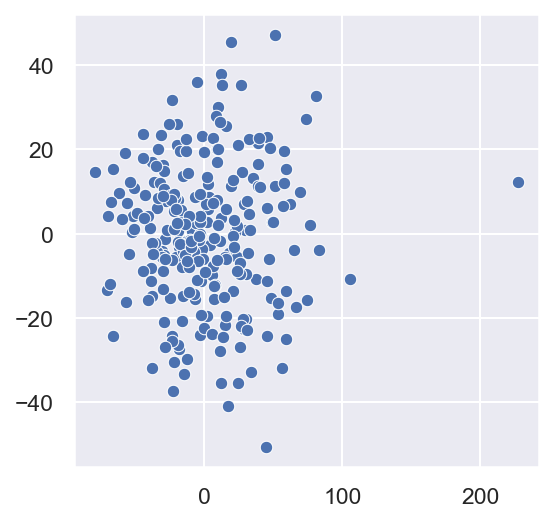

In [116]:
u, s, vt = np.linalg.svd(body_data_centered, full_matrices = False)
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [117]:
np.argmax(pcs[:, 0])

38

In [118]:
body_data.iloc[38, :]

% brozek fat        33.8000
% siri fat          35.2000
density              1.0202
age                 46.0000
weight             363.1500
height              72.2500
adiposity           48.9000
fat free weight    240.5000
neck                51.2000
chest              136.2000
abdomen            148.1000
hip                147.7000
thigh               87.3000
knee                49.1000
ankle               29.6000
bicep               45.0000
forearm             29.0000
wrist               21.4000
Name: 38, dtype: float64

## Election Data

In [119]:
from ds100_utils import fetch_and_cache
import yaml
from datetime import datetime


base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Using cached version that was downloaded (UTC): Mon Dec 27 06:04:40 2021


<ipython-input-119-0c6ae75a7c84>:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  legislators_data = yaml.load(open(f))


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [120]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
votes = pd.read_csv('data/votes.csv')
votes = votes.astype({"roll call": str}) 
votes.head()

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [121]:
def was_yes(s):
    if s.iloc[0] == 'Yes':
        return 1
    else:
        return 0
    
vote_pivot = votes.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=was_yes, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()    

(441, 41)


roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000367,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,1,1,0,1
A000369,1,1,0,0,1,1,0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,1,1


In [122]:
vote_pivot_centered = vote_pivot - np.mean(vote_pivot, axis = 0)
vote_pivot_centered.head(5)

roll call,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.129252,-0.668934,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000367,-0.870748,-0.668934,-0.526077,-0.52381,-0.950113,-0.412698,-0.562358,-0.365079,-0.405896,-0.439909,...,-0.521542,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,-0.913832,0.496599
A000369,0.129252,0.331066,-0.526077,-0.52381,0.049887,0.587302,-0.562358,0.634921,0.594104,0.560091,...,-0.521542,-0.526077,0.045351,-0.521542,-0.519274,0.54195,-0.521542,-0.535147,0.086168,-0.503401
A000370,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599
A000371,0.129252,0.331066,0.473923,0.47619,0.049887,-0.412698,0.437642,-0.365079,-0.405896,-0.439909,...,0.478458,0.473923,0.045351,0.478458,0.480726,-0.45805,0.478458,0.464853,0.086168,0.496599


In [123]:
u, s, vt = np.linalg.svd(vote_pivot_centered, full_matrices = False)

In [124]:
np.round(s**2 / sum(s**2), 2)

array([0.8 , 0.05, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

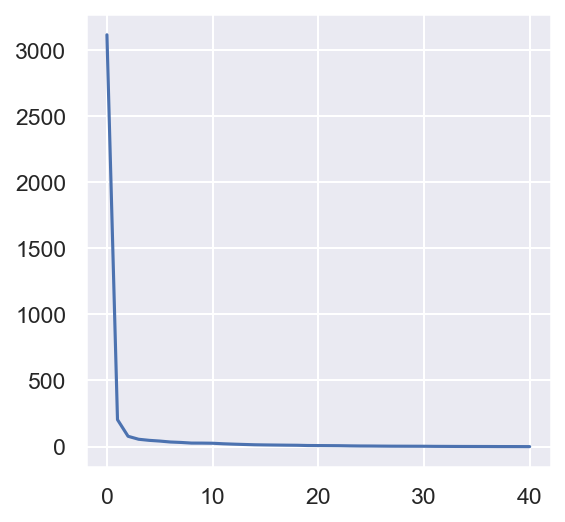

In [125]:
plt.plot(s**2)

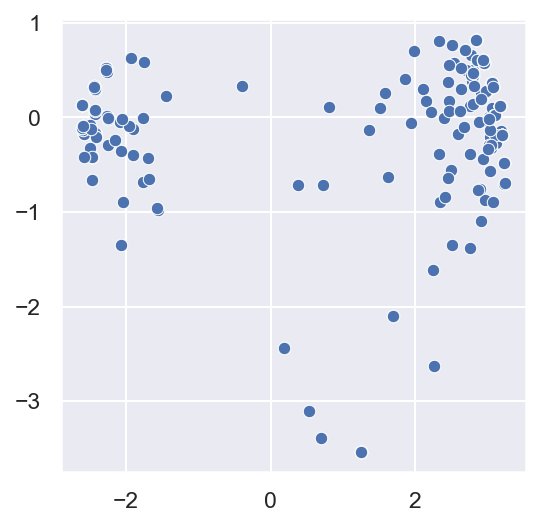

In [126]:
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [127]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

Democrat      228
Republican      1
Name: party, dtype: int64

In [128]:
#top right only
vote2d.query('pc2 > -2 and pc1 > 0')['party'].value_counts()

Republican    190
Name: party, dtype: int64

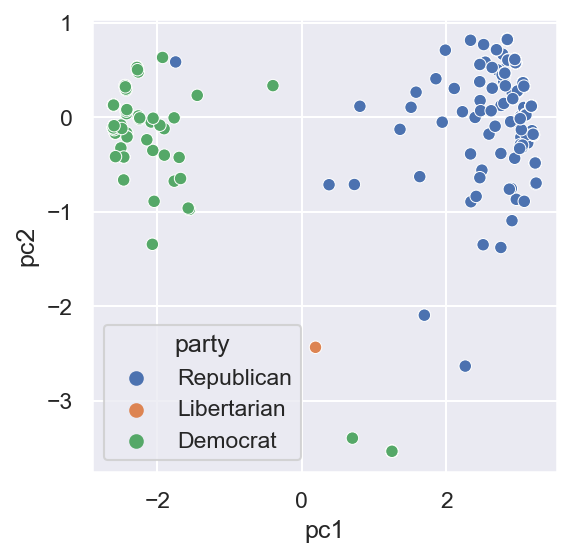

In [129]:
sns.scatterplot(x="pc1", y="pc2", hue="party", data = vote2d);

In [130]:
vote2d['pc1_jittered'] = vote2d['pc1'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])
vote2d['pc2_jittered'] = vote2d['pc2'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])

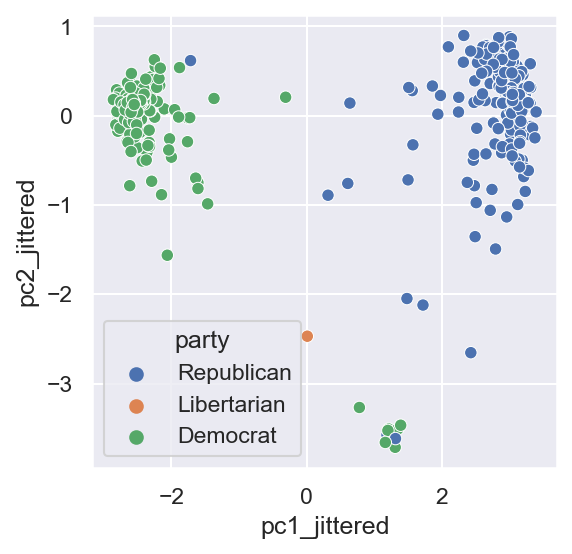

In [131]:
sns.scatterplot(x="pc1_jittered", y="pc2_jittered", hue="party", data = vote2d);

In [132]:
vote2d.head(5)

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday,pc1_jittered,pc2_jittered
0,A000055,3.061356,0.364191,A000055,Robert,Aderholt,M,AL,rep,Republican,1965-07-22,2.910817,0.438914
1,A000367,0.188870,-2.433565,A000367,Justin,Amash,M,MI,rep,Libertarian,1980-04-18,0.006800,-2.469279
2,A000369,2.844370,0.821619,A000369,Mark,Amodei,M,NV,rep,Republican,1958-06-12,2.863910,0.688568
3,A000370,-2.607536,0.127977,A000370,Alma,Adams,F,NC,rep,Democrat,1946-05-27,-2.703584,0.152734
4,A000371,-2.607536,0.127977,A000371,Pete,Aguilar,M,CA,rep,Democrat,1979-06-19,-2.792638,0.032556


In [133]:
vote2d[vote2d['pc1'] > 0]['party'].value_counts()

Republican     195
Democrat         7
Libertarian      1
Name: party, dtype: int64

In [134]:
vote2d[vote2d['pc2'] < -1]

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday,pc1_jittered,pc2_jittered
1,A000367,0.188870,-2.433565,A000367,Justin,Amash,M,MI,rep,Libertarian,1980-04-18,0.006800,-2.469279
6,A000374,1.247134,-3.533196,A000374,Ralph,Abraham,M,LA,rep,Republican,1954-09-16,1.183863,-3.575520
47,B001311,1.695651,-2.093912,B001311,Dan,Bishop,M,NC,rep,Republican,1964-07-01,1.715422,-2.120233
50,C000537,0.699636,-3.394179,C000537,James,Clyburn,M,SC,rep,Democrat,1940-07-21,0.776201,-3.267397
68,C001087,2.755060,-1.378193,C001087,Eric,Crawford,M,AR,rep,Republican,1966-01-22,2.787311,-1.492198
148,G000582,2.262007,-2.632452,G000582,Jenniffer,Gonzﾃ｡lez-Colﾃｳn,F,PR,rep,Republican,1976-08-05,2.422000,-2.653682
176,H001077,2.509474,-1.349023,H001077,Clay,Higgins,M,LA,rep,Republican,1961-08-24,2.485465,-1.354204
192,J000299,2.908823,-1.094618,J000299,Mike,Johnson,M,LA,rep,Republican,1972-01-30,2.708570,-1.059145
266,M001200,1.247134,-3.533196,M001200,A.,McEachin,M,VA,rep,Democrat,1961-10-10,1.209981,-3.508706
276,M001210,1.695651,-2.093912,M001210,Gregory,Murphy,M,NC,rep,Republican,1963-03-05,1.478506,-2.047132


In [135]:
df = votes[votes['member'].isin(vote2d[vote2d['pc2'] < -1]['member'])]
df.groupby(['member', 'vote']).size()

member   vote      
A000367  No            31
         Yes           10
A000374  Not Voting    41
B001311  No            17
         Yes            7
C000537  No             1
         Not Voting    37
         Yes            3
C001087  No             6
         Not Voting    23
         Yes           12
G000582  Not Voting     1
         Yes            6
H001077  No            14
         Not Voting    15
         Yes           12
J000299  No            20
         Not Voting     7
         Yes           14
M001200  Not Voting    41
M001210  No            16
         Not Voting     1
         Yes            7
N000147  No             6
         Not Voting     1
P000197  Speaker       41
P000610  No             7
R000577  No            11
         Not Voting     8
         Yes           22
R000600  Not Voting     7
S001177  No             7
S001204  No             6
         Not Voting     1
dtype: int64

In [136]:
legs.query("leg_id == 'A000367'")

,leg_id,first,last,gender,state,chamber,party,birthday
33,A000367,Justin,Amash,M,MI,rep,Libertarian,1980-04-18


### Let's look at only people who have voted more than 15 times lately

In [137]:
votes.head(5)

,chamber,session,roll call,member,vote
0,House,1,555,A000374,Not Voting
1,House,1,555,A000370,Yes
2,House,1,555,A000055,No
3,House,1,555,A000371,Yes
4,House,1,555,A000372,No


In [138]:
num_yes_or_no_votes_per_member = votes.query("vote == 'Yes' or vote == 'No'").groupby("member").size()
num_yes_or_no_votes_per_member.head(5)

member
A000055    40
A000367    41
A000369    41
A000370    41
A000371    41
dtype: int64

In [139]:
vote_pivot_with_yes_no_count = vote_pivot.merge(num_yes_or_no_votes_per_member.to_frame(), left_index = True, right_index = True, how="outer", ).fillna(0)
vote_pivot_with_yes_no_count = vote_pivot_with_yes_no_count.rename(columns = {0: 'yes_no_count'})
vote_pivot_with_yes_no_count.head(5)

,515,516,517,518,519,520,521,522,523,524,...,547,548,549,550,551,552,553,554,555,yes_no_count
member,,,,,,,,,,,,,,,,,,,,,
A000055,1,0,0,0,1,1,0,1,1,1,...,0,1,0,0,1,0,0,1,0,40.0
A000367,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,0,1,41.0
A000369,1,1,0,0,1,1,0,1,1,1,...,0,1,0,0,1,0,0,1,0,41.0
A000370,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,41.0
A000371,1,1,1,1,1,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,41.0


In [140]:
regulars = vote_pivot_with_yes_no_count.query('yes_no_count >= 30')
regulars = regulars.drop('yes_no_count', 1)
regulars.shape

(425, 41)

In [141]:
regulars_centered = regulars - np.mean(regulars, axis = 0)
regulars_centered.head(5)

,515,516,517,518,519,520,521,522,523,524,...,546,547,548,549,550,551,552,553,554,555
member,,,,,,,,,,,,,,,,,,,,,
A000055,0.101176,-0.691765,-0.543529,-0.541176,0.023529,0.581176,-0.581176,0.625882,0.588235,0.550588,...,-0.541176,-0.545882,0.014118,-0.538824,-0.536471,0.529412,-0.538824,-0.555294,0.056471,-0.522353
A000367,-0.898824,-0.691765,-0.543529,-0.541176,-0.976471,-0.418824,-0.581176,-0.374118,-0.411765,-0.449412,...,-0.541176,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,-0.943529,0.477647
A000369,0.101176,0.308235,-0.543529,-0.541176,0.023529,0.581176,-0.581176,0.625882,0.588235,0.550588,...,-0.541176,-0.545882,0.014118,-0.538824,-0.536471,0.529412,-0.538824,-0.555294,0.056471,-0.522353
A000370,0.101176,0.308235,0.456471,0.458824,0.023529,-0.418824,0.418824,-0.374118,-0.411765,-0.449412,...,0.458824,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,0.056471,0.477647
A000371,0.101176,0.308235,0.456471,0.458824,0.023529,-0.418824,0.418824,-0.374118,-0.411765,-0.449412,...,0.458824,0.454118,0.014118,0.461176,0.463529,-0.470588,0.461176,0.444706,0.056471,0.477647


In [142]:
u, s, vt = np.linalg.svd(regulars_centered, full_matrices = False)

In [143]:
np.round(s**2 / sum(s**2), 2)

array([0.84, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

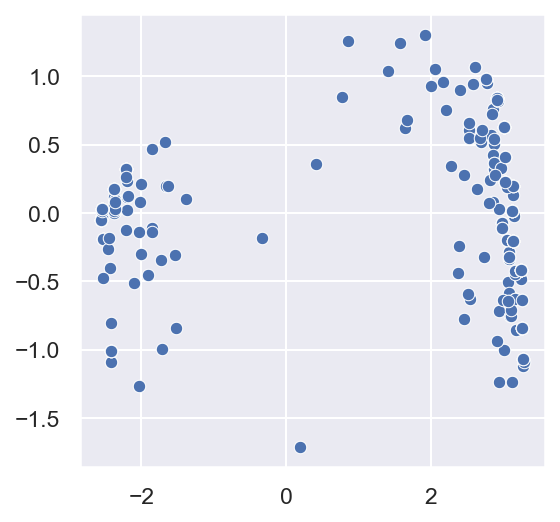

In [144]:
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);

In [145]:
vote2d = pd.DataFrame({
    'member': regulars_centered.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d['pc1_jittered'] = vote2d['pc1'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])
vote2d['pc2_jittered'] = vote2d['pc2'] + np.random.normal(loc = 0, scale = 0.1, size = vote2d.shape[0])

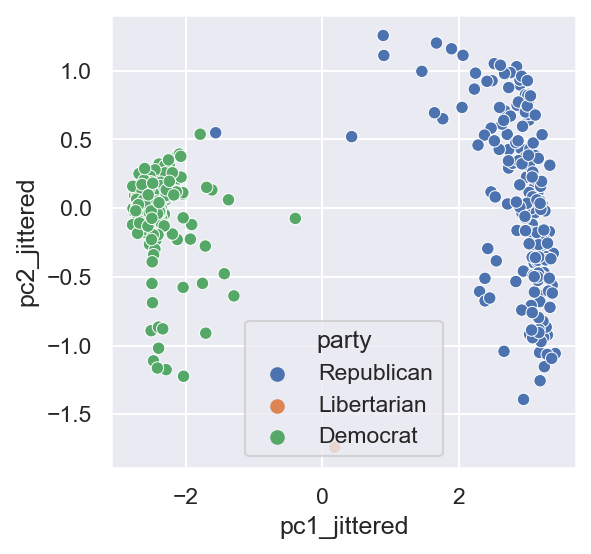

In [146]:
sns.scatterplot(x="pc1_jittered", y="pc2_jittered", hue="party", data = vote2d);

## Exploring $V^T$

We can also look at Vt directly to try to gain insight into why each component is as it is.

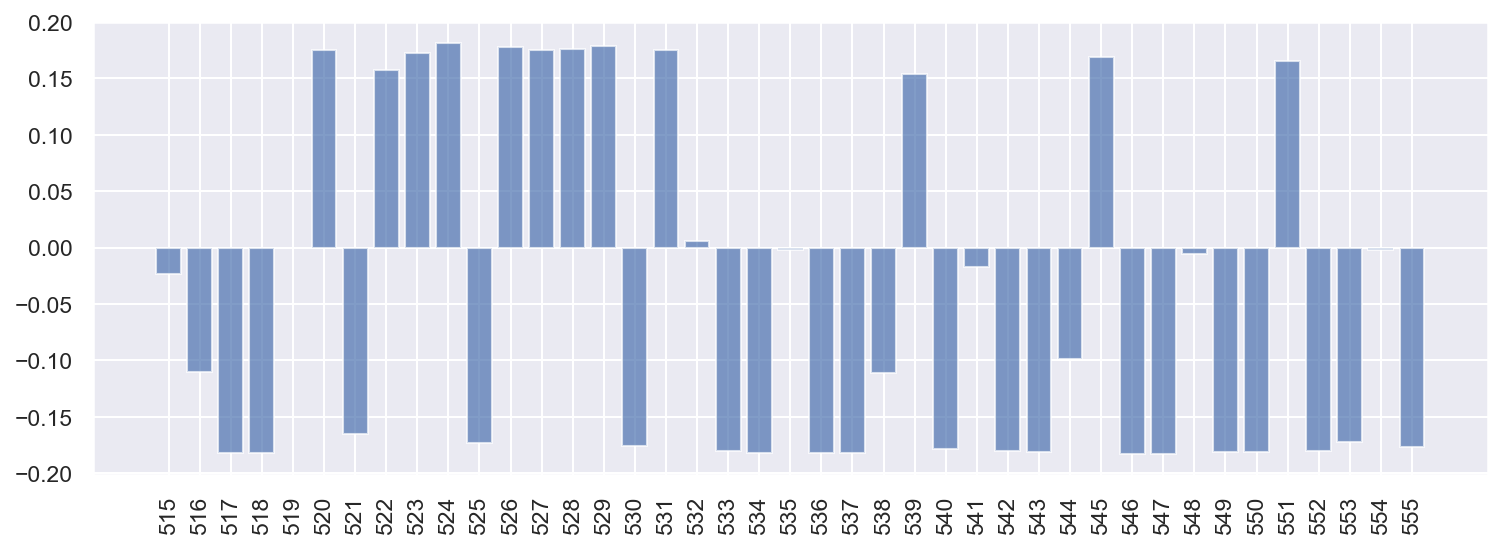

In [147]:
num_votes = vt.shape[1]
votes = regulars.columns

def plot_pc(k):
    plt.bar(votes, vt[k, :], alpha=0.7)
    plt.xticks(votes, rotation=90);

with plt.rc_context({"figure.figsize": (12, 4)}):
    plot_pc(0)
#   plot_pc(1)

In [148]:
def compute_rank_k_approximation(data, k):
    u, s, vt = np.linalg.svd(data, full_matrices = False)
    return pd.DataFrame(u[:, 0:k] @ np.diag(s[0:k]) @ vt[0:k, :], columns = data.columns)

## PCA vs. Linear Regression (Bonus)

Now we'll finally turn to trying to understand what the principle components and the low rank approximations actually mean!

Returning to our child mortality data from before, if we zero-center the child data, we see get back a better result. Note that we have to add back in the mean of each column to get things back into the right units.

In [149]:
means = np.mean(child_data, axis = 0)
child_data_centered = child_data - np.mean(child_data, axis = 0)
child_data_rank_1_approximation = compute_rank_k_approximation(child_data_centered, 1) + means

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


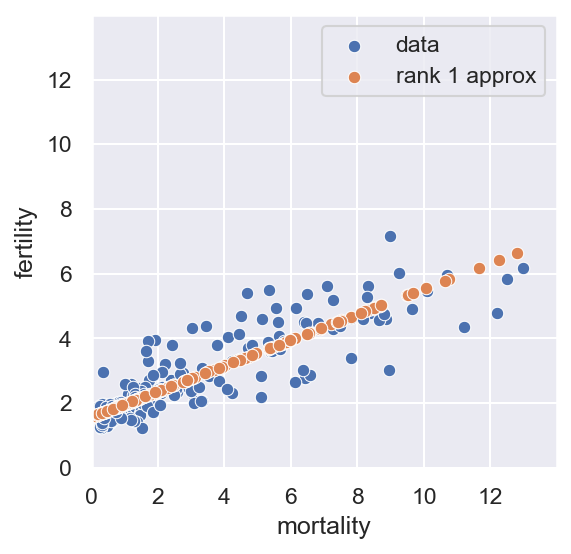

In [150]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.scatterplot('mortality', 'fertility', data=child_data_rank_1_approximation)
plt.legend(['data', 'rank 1 approx'])
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

We can also give our rank 1 approximation as a line, showing the 1D subspace (in black) that our data is being projected onto.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


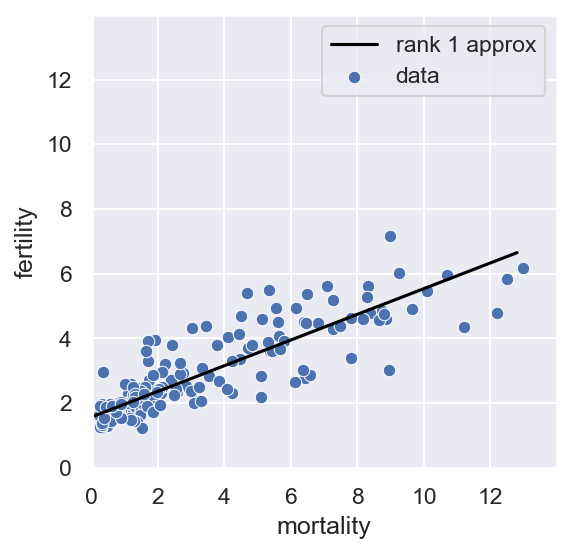

In [151]:
sns.scatterplot('mortality', 'fertility', data=child_data)
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color='black')
plt.legend(['rank 1 approx', 'data']);
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

This plot probably brings to mind linear regression from Data 8. But PCA is NOT the same thing linear regression. Let's plot the regression lines for this data for comparison. Recall that the regression line gives us, e.g. the best possible linear prediction of the fertility given the mortality.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


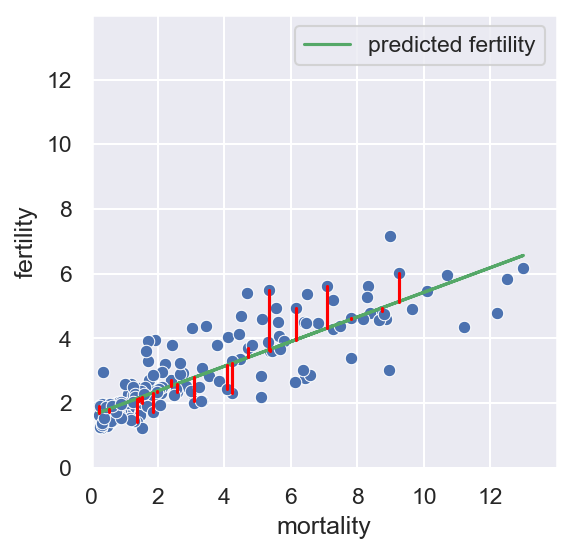

In [152]:
x, y = child_data['mortality'], child_data['fertility']
slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression

scatter14(child_data)

plt.plot(x, slope_x * x + intercept_x, c = 'g')
for _, row in child_data.sample(20).iterrows():
    tx, ty = row['mortality'], row['fertility']
    plt.plot([tx, tx], [slope_x * tx + intercept_x, ty], c='red')
    
plt.legend(['predicted fertility']);

In the plot above, the green regression line given minimizes the sum of the squared errors, given as red vertical lines.

We could also do the opposite thing, and try to predict fertility from mortality.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


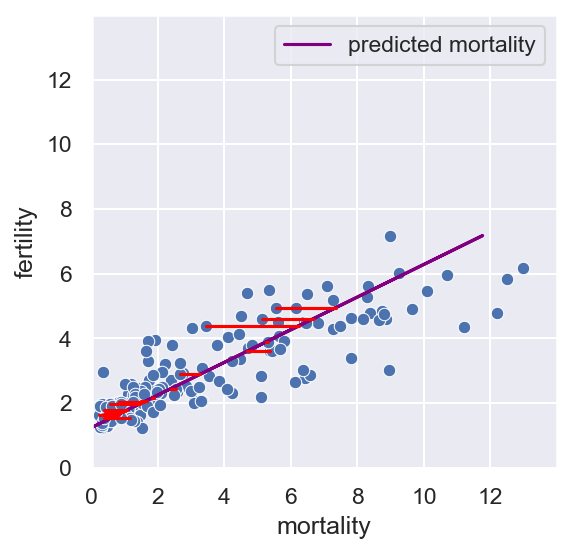

In [153]:
x, y = child_data['mortality'], child_data['fertility']
slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression

scatter14(child_data)

plt.plot(slope_y * y + intercept_y, y, c = 'purple')
for _, row in child_data.sample(20).iterrows():
    tx, ty = row['mortality'], row['fertility']
    plt.plot([tx, slope_y * ty + intercept_y], [ty, ty], c='red')
    
plt.legend(['predicted mortality']);

In the plot above, the green regression line given minimizes the sum of the squared errors, given as red horizontal lines.

Plotting the two regression lines and the 1D subspace chosen by PCA, we see that all 3 are distinct!

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


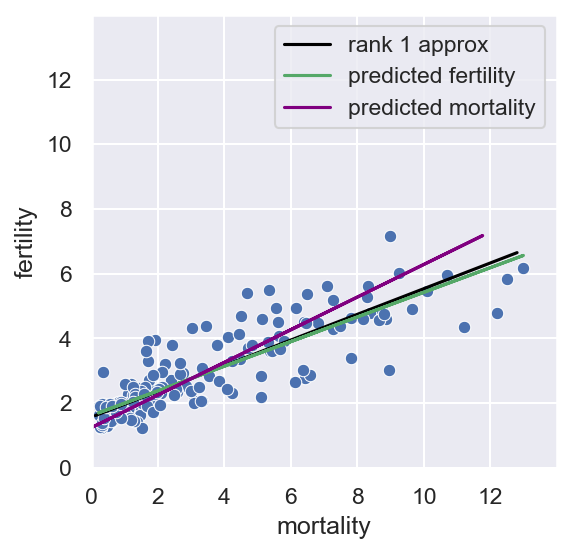

In [154]:
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color="black")
plt.plot(x, slope_x * x + intercept_x, c = 'g')
plt.plot(slope_y * y + intercept_y, y, c = 'purple');
sns.scatterplot('mortality', 'fertility', data=child_data)
plt.legend(['rank 1 approx', 'predicted fertility', 'predicted mortality'])
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));

Given that the green line minimizes the "vertical error" and the purple line minimizes the "horizontal error". You might wonder what the black line minimizes. It turns out, it minimizes the "diagonal" error, i.e. the error in the direction perpendicular to itself.

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


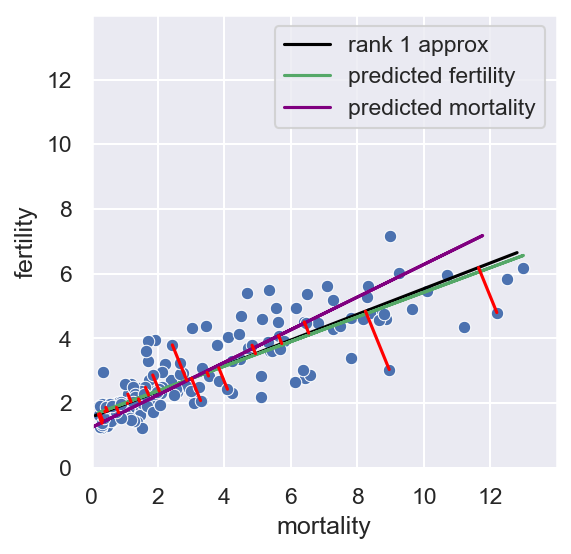

In [155]:
sns.lineplot('mortality', 'fertility', data=child_data_rank_1_approximation, color="black")
plt.plot(x, slope_x * x + intercept_x, c = 'g')
plt.plot(slope_y * y + intercept_y, y, c = 'purple');
sns.scatterplot('mortality', 'fertility', data=child_data)

for idx, tdata in child_data.reset_index().sample(20).iterrows():
    tx = tdata["mortality"]
    ty = tdata["fertility"]
    tx_projected = child_data_rank_1_approximation.iloc[idx, 0]
    ty_projected = child_data_rank_1_approximation.iloc[idx, 1]
    plt.plot([tx, tx_projected], [ty, ty_projected], c='red')
    
plt.xlim([0, 14])
plt.ylim([0, 14])
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(0, 14, 2));
plt.legend(['rank 1 approx', 'predicted fertility', 'predicted mortality']);

The function in the following cell makes it easy to make similar plots for whatever dataset you might be interested in.

In [156]:
def plot_x_regression_y_regression_1d_approximation(data): 
    xname = data.columns[0]
    yname = data.columns[1]
    
    x, y = data[xname], data[yname]
    slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression
    
    x, y = data[xname], data[yname]
    slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression
    
    means = np.mean(data, axis = 0)
    rank_1_approximation = compute_rank_k_approximation(data - means, 1) + means
    
    sns.lineplot(x=xname, y=yname, data=rank_1_approximation, color="black")
    plt.plot(x, slope_x * x + intercept_x, c = 'g')
    plt.plot(slope_y * y + intercept_y, y, c = 'purple');
    sns.scatterplot(xname, yname, data=data)
    
   
    for idx, tdata in data.reset_index().sample(20).iterrows():
        tx = tdata[xname]
        ty = tdata[yname]
        
        tx_projected = rank_1_approximation.iloc[idx, 0]
        ty_projected = rank_1_approximation.iloc[idx, 1]
        plt.plot([tx, tx_projected], [ty, ty_projected], c='red') 
    
    plt.legend(['1D PCA Subspace', 'predicted ' + xname, 'predicted ' + yname])

C:\Users\koiso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


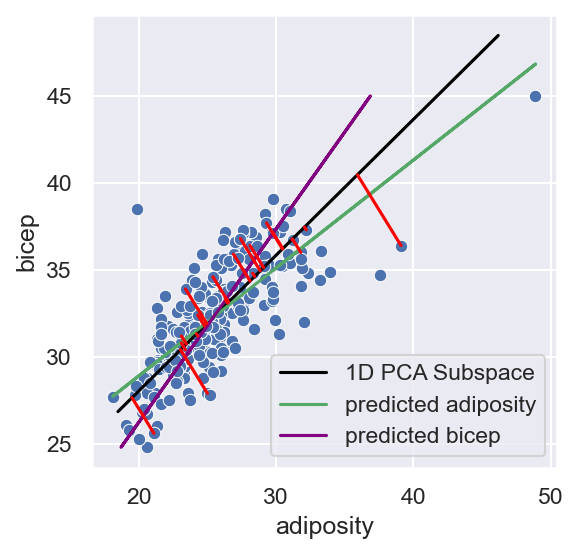

In [157]:
plot_x_regression_y_regression_1d_approximation(body_data.drop(41)[["adiposity", "bicep"]])